## Lab: RNN with Forecasting

### Wind Turbine Power Prediction with RNN

This lab uses a Recurrent Neural Network to predict wind turbine power output.
* [Data link](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

### Step 0: Load libraries & Data

In [1]:
# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
df = pd.read_csv('T1.csv')

2025-05-30 03:19:49.912718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Display basic information
print(df.shape)
df.head()

(50530, 5)


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


### Step 1: Prepare the data

In [3]:
# Step 1: Prepare the data
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df.isnull().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [4]:
# No missing entries, that makes things easier
df.describe()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,1307.684332,7.557952,1492.175463,123.687559
min,2018-01-01 00:00:00,-2.471405,0.000000,0.000000,0.000000
25%,2018-04-03 05:22:30,50.677890,4.201395,161.328167,49.315437
50%,2018-06-30 16:15:00,825.838074,7.104594,1063.776283,73.712978
75%,2018-09-26 18:57:30,2482.507568,10.300020,2964.972462,201.696720
max,2018-12-31 23:50:00,3618.732910,25.206011,3600.000000,359.997589
std,NaN,1312.459242,4.227166,1368.018238,93.443736


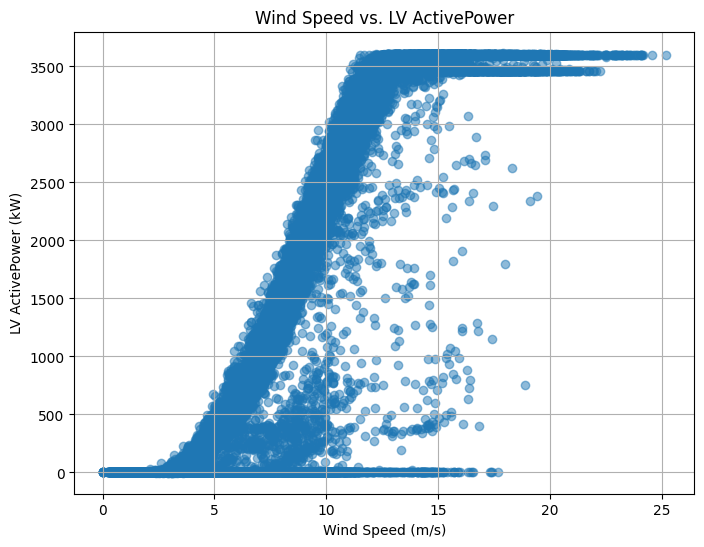

In [5]:
# Scatter plot of Wind Speed vs. LV ActivePower
plt.figure(figsize=(8, 6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Wind Speed vs. LV ActivePower')
plt.grid(True)
plt.show()

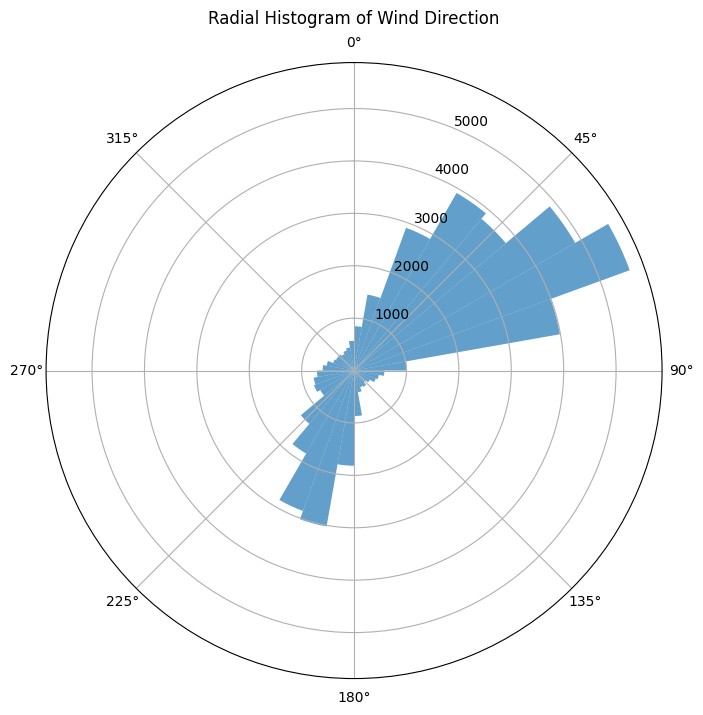

In [6]:
# Convert wind direction to radians
wind_direction_radians = np.deg2rad(df['Wind Direction (°)'])

# Create bins for wind direction (0 to 360 degrees, mapped to radians)
num_bins = 36  # Adjust granularity as needed
hist, bin_edges = np.histogram(wind_direction_radians, bins=num_bins)

# Create a polar histogram
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
bars = ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge', alpha=0.7)

# Adjust aesthetics
ax.set_theta_zero_location('N')  # Set 0° at the top (north)
ax.set_theta_direction(-1)  # Clockwise orientation
ax.set_title('Radial Histogram of Wind Direction', va='bottom')

plt.show()


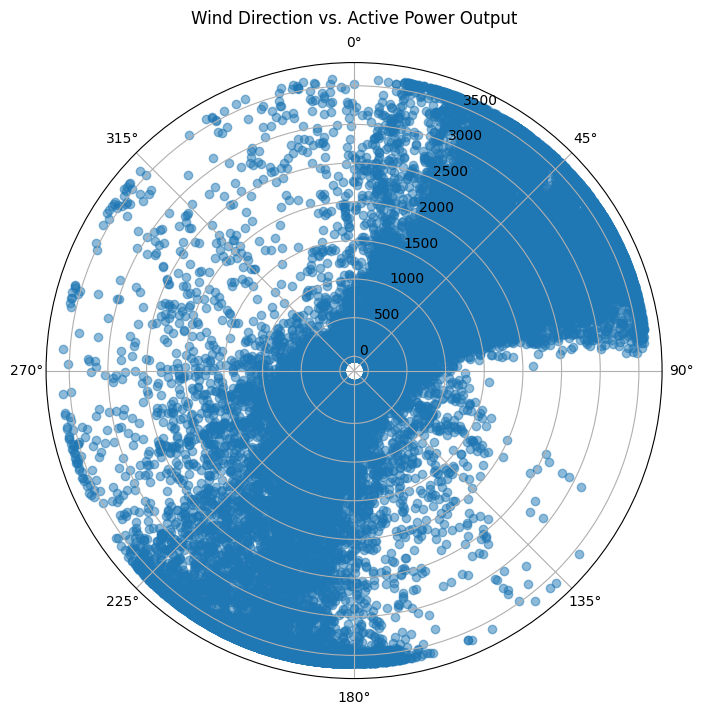

In [7]:
df['Wind Direction (radians)'] = np.deg2rad(df['Wind Direction (°)'])

# Polar scatter plot of Wind Direction vs. Active Power
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.scatter(df['Wind Direction (radians)'], df['LV ActivePower (kW)'], alpha=0.5)

ax.set_theta_zero_location('N')  # Set 0° at the top (north)
ax.set_theta_direction(-1)  # Clockwise direction

ax.set_title('Wind Direction vs. Active Power Output', va='bottom')
plt.show()

### Brief EDA Comments

 - As we have no objective standard to compare, we'll assume 0 degrees is true north.
 - Wind direction is typically defined by where it's coming from
 - The data set is dominated by northeasterly winds, with some south by southwest for the music lovers
 - The southeast quadrant appears particularly weak for generating power

In [8]:
# Scale
data = df[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']]
target = df['LV ActivePower (kW)']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Stuff it back into a DF just in case
data_scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

### Step 2: Create sequences

In [9]:
def create_sequences(data, target, seq_length=24):
    X = []
    y = []

    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Collect sequence window
        y.append(target[i])  # Target is the value right after the window

    X = np.array(X)
    y = np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))  # Reshape for model input compatibility

    return X, y

X, y = create_sequences(data, target)

X.shape, y.shape

((50506, 24, 3), (50506,))

### Step 3: Split the data

In [10]:
# Step 3: Split the data
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]

y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape
# Choo, choo! chugga chugga chugga chugga 

((40404, 24, 3), (10102, 24, 3))

### Step 4: Build the RNN Model

In [11]:
# Step 4: Build the RNN Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(24, 3)),
    Dropout(0.2),  
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the model

In [12]:
# Step 5: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('super_best_model.keras', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)


Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 3056926.0000 - val_loss: 3813393.0000
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 2935503.5000 - val_loss: 3668767.2500
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2825257.5000 - val_loss: 3529722.7500
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 2718750.0000 - val_loss: 3395413.2500
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 2617491.5000 - val_loss: 3265382.2500
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 2518135.0000 - val_loss: 3139122.2500
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2423464.2500 - val_loss: 3016674.0000
Epoch 8/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2331814.7500 - val_loss: 2897973.2500
Epoch 9/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 2242303.7500 - val_loss: 2782675.2500
Epoch 10/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2156133.2500 - va

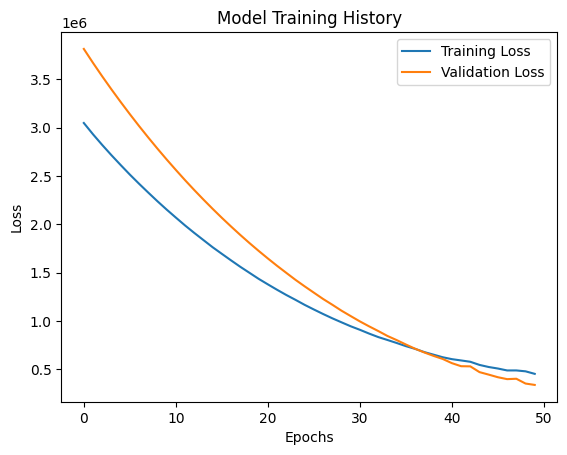

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

### Step 6: Evaluate on the test data and visualize the results

In [14]:
# Step 6: Evaluate and visualize
y_pred = model.predict(X_test)

# Reshape predictions for inverse transformation
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Create a separate scaler for the target variable
target_scaler = MinMaxScaler()
target_scaler.fit(y_train.reshape(-1, 1))  # Fit only on the target column

# Apply inverse transformation using the correct scaler
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test)

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 2544488.7645
R² Score: 0.7258


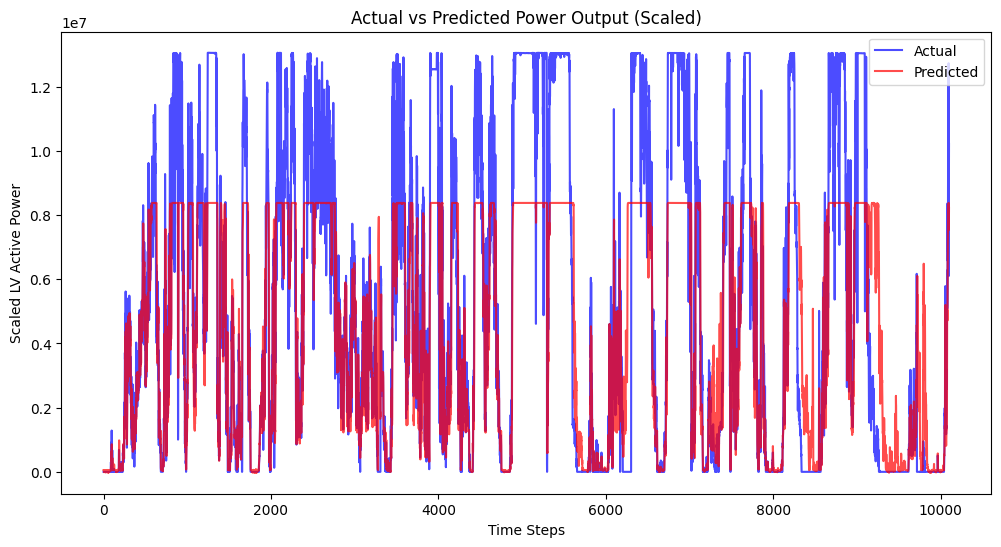

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual", color='blue', alpha=0.7)
plt.plot(y_pred_inv, label="Predicted", color='red', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Scaled LV Active Power")
plt.title("Actual vs Predicted Power Output (Scaled)")
plt.legend()
plt.show()


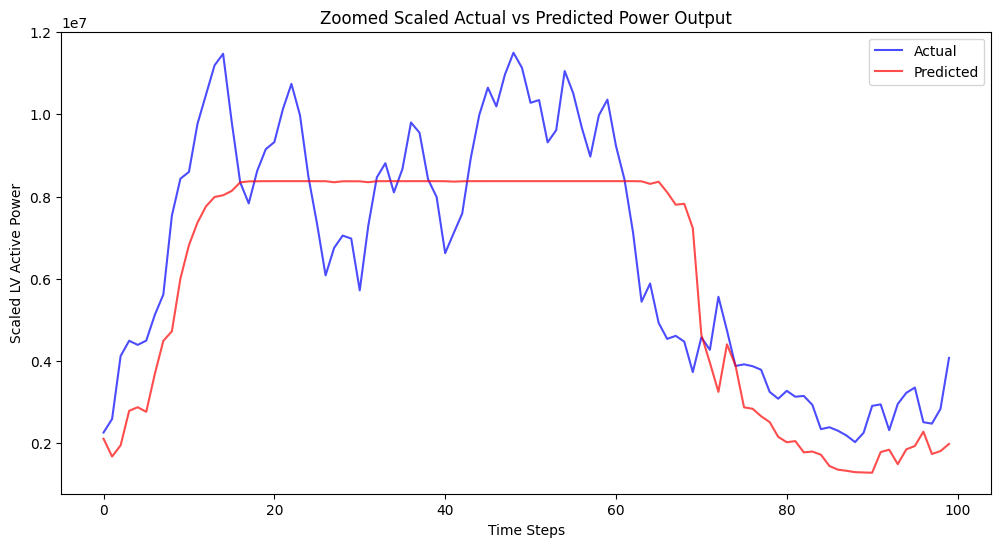

In [16]:
# Def window
start_idx, end_idx = 1000, 1100 

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[start_idx:end_idx], label="Actual", color='blue', alpha=0.7)
plt.plot(y_pred_inv[start_idx:end_idx], label="Predicted", color='red', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Scaled LV Active Power")
plt.title("Zoomed Scaled Actual vs Predicted Power Output")
plt.legend()
plt.show()
